In [159]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import json
import math
import numpy as np
import os

import cv2
print(cv2.__version__)
#import sys; print('Python %s on %s' % (sys.version, sys.platform))


3.4.2


In [160]:
# load the stuff. Please set up the following paths:
path_to_images = 'C:/p/herox/Data_Training'
path_to_labels = 'C:/p/herox/training_GT_labels.json'
path_to_results = 'C:/p/herox/results/exploration'

# : loading list of file names and labels dict:
with os.scandir(path_to_images) as it:
    set_of_image_file_names = {entry.name for entry in it
                               if entry.is_file()
                               and not entry.name.startswith('.')
                               and entry.name.endswith(('.jpg', '.JPG'))
                               }
    
with open(path_to_labels) as f:
    dict_of_labels = json.load(f)

set_of_images_with_labels = set_of_image_file_names & dict_of_labels.keys()
print('found {} images and {} labels.'.format(len(set_of_image_file_names), len(dict_of_labels)))
print('{} images with labels'.format(len(set_of_images_with_labels)))
print('{} images without labels'.format(len(set_of_image_file_names - dict_of_labels.keys())))
print('{} labels without images'.format(len(dict_of_labels.keys() - set_of_image_file_names)))

dict_of_incomplete_labels = {file_name: label for (file_name, label) in dict_of_labels.items()
                             if len(label) != 1 or len(label[0]) != 8}
print('{} incomplete labels:'.format(len(dict_of_incomplete_labels)))
print(dict_of_incomplete_labels)

set_of_images_with_labels = set_of_images_with_labels - dict_of_incomplete_labels.keys()
dict_of_labels = {file_name: label[0] for (file_name, label) in dict_of_labels.items()
                  if file_name in set_of_images_with_labels}
print('{} images with complete labels'.format(len(set_of_images_with_labels)))
work_list_of_images = list(set_of_images_with_labels)
work_list_of_images.sort()

found 9339 images and 9339 labels.
9339 images with labels
0 images without labels
0 labels without images
5 incomplete labels:
{'IMG_0688.JPG': [[]], 'IMG_6608.JPG': [[]], 'IMG_1343.JPG': [[]], 'IMG_5199.JPG': [[]], 'IMG_0492.JPG': [[]]}
9334 images with complete labels


In [188]:
gate_size_in_pix = 200
frame_thickness_to_gate_size_ratio = 1./5.

frame_thickness_in_pix = gate_size_in_pix * frame_thickness_to_gate_size_ratio
frame_padding_in_pix = frame_thickness_in_pix
gate_padding_in_pix = frame_padding_in_pix + frame_thickness_in_pix

frame_size_in_pix = gate_size_in_pix + 2 * frame_thickness_in_pix
rectified_gate_img_size_in_pix = int(frame_size_in_pix + 2 * frame_padding_in_pix + 0.5)

gate_coords = np.array((
    (gate_padding_in_pix, gate_padding_in_pix),
    (gate_padding_in_pix + gate_size_in_pix, gate_padding_in_pix),
    (gate_padding_in_pix + gate_size_in_pix, gate_padding_in_pix + gate_size_in_pix),
    (gate_padding_in_pix, gate_padding_in_pix + gate_size_in_pix),
), dtype = "float32")

frame_coords = np.array((
    (frame_padding_in_pix, frame_padding_in_pix),
    (frame_padding_in_pix + frame_size_in_pix, frame_padding_in_pix),
    (frame_padding_in_pix + frame_size_in_pix, frame_padding_in_pix + frame_size_in_pix),
    (frame_padding_in_pix, frame_padding_in_pix + frame_size_in_pix),
), dtype = "float32")


#
# primitive functions to get the stuff:
#

def get_labled_gate_coords(label):
    '''
    takes label as a list of exactly 8 numbers as they are given in herox labels:
    four pairs of (x,y)-coordinates of clockwise ordered corners.
    returns the coordinates as np.array of shape (4,2)
    '''
    return np.array((
        (label[0], label[1]),
        (label[2], label[3]),
        (label[4], label[5]),
        (label[6], label[7]),
    ), dtype = "float32")


def get_img2gate_homography(labled_gate_coords):
    return cv2.getPerspectiveTransform(labled_gate_coords, gate_coords)

def get_gate2img_homography(labled_gate_coords):
    return cv2.getPerspectiveTransform(gate_coords, labled_gate_coords)

def get_transformed_label(lable_coords, homograpy):
    return cv2.perspectiveTransform(np.float32([lable_coords]), homograpy)

def get_gate_frame_label(gate2img_homography):
    return get_transformed_label(frame_coords, gate2img_homography)


def draw_label(image, lable_coords, color=(255, 0, 255), thickness=3):
    cv2.polylines(image,
                  np.int32([lable_coords]),
                  isClosed=True, color=color, thickness=thickness, lineType=8)
    return image


def get_image_with_gate_label(image_file_name):
    image = cv2.imread(os.path.join(path_to_images, image_file_name))
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_label = cv2.cvtColor(image_bw, cv2.COLOR_GRAY2BGR)
    label = dict_of_labels[image_file_name]
    labled_gate_coords = get_labled_gate_coords(label)
    return image, labled_gate_coords, draw_label(image_label, labled_gate_coords, color=(255, 0, 255), thickness=3)


def get_rectified_gate_image(image, img2gate_homography):
    return cv2.warpPerspective(image,
                               img2gate_homography,
                               (rectified_gate_img_size_in_pix,
                                rectified_gate_img_size_in_pix),
                               borderValue=(0,0,255))


def labled_image_to_exploration_images(image_file_name):
    image, labled_gate_coords, image_label = get_image_with_gate_label(image_file_name)
    # draw the gate's frame expected corners:
    gate2img_homography = get_gate2img_homography(labled_gate_coords)
    frame_label_coords = get_gate_frame_label(gate2img_homography)
    image_label = draw_label(image_label, frame_label_coords, color=(0, 255, 0), thickness=2)
    img2gate_homography = get_img2gate_homography(labled_gate_coords)
    # make 'rectified' image of the gate:
    image_label_rectified = get_rectified_gate_image(image_label, img2gate_homography)
    #image_label_rectified = draw_label(image_label_rectified, frame_coords, color=(0, 255, 0), thickness=1)
    return {'original': image, 'label': image_label, 'rectified': image_label_rectified }


def labled_image_to_exploration_image_file(src_image_file_name, dst_image_path):
    images = labled_image_to_exploration_images(src_image_file_name)
    label_image = images['label']
    rectified_label_image = images['rectified']
    # : stack them horizontally:
    res_h = rectified_label_image.shape[0]
    label_image_scale = float(res_h) / label_image.shape[0]
    label_image = cv2.resize(label_image, None, fx=label_image_scale, fy=label_image_scale)
    div_w = 2
    label_image_w = label_image.shape[1]
    res_w = label_image_w + div_w + rectified_label_image.shape[1]
    stacked_images = np.zeros((res_h, res_w, 3), dtype="uint8")
    stacked_images[:, :label_image_w] = label_image
    stacked_images[:, label_image_w + div_w:] = rectified_label_image
    cv2.imwrite(dst_image_path, stacked_images)



In [194]:
def homography_to_2d_sx_sy_shear(h):
    '''
    takes 3x3 homography matrics h
    returns (scale_x, scale_y, shear)
    '''
    
    '''
    1. (taken from https://stackoverflow.com/a/34399034/1027013)
        If whole homography is:

        h1 h2 h3
        h4 h5 h6
        h7 h8 1

        then its normalized 2x2 part:

        A = Q*R = [[a,b];[c,d]] =
        [[h1-(h7*h3)   h2-(h8*h3)]
         [h4-(h7*h6)   h5-(h8*h6)]]
    '''
    a = h[0,0] - h[2,0]*h[0,2]
    b = h[0,1] - h[2,1]*h[0,2]
    c = h[1,0] - h[2,0]*h[1,2]
    d = h[1,1] - h[2,1]*h[1,2]
    
    '''
    2. (taken from https://stackoverflow.com/a/16085365/1027013)
    '''
    detA = a*d - b*c
    sx = math.sqrt(a*a + b*b)
    sy = detA / sx
    shear = (a*c + b*d) / detA
    return (sx, sy, shear)

def homography_to_2d_cam_invariants(h):
    '''
    takes 3x3 homography matrics h
    returns (scale_x/scale_y, abs(shear))
    '''
    sx,sy,shear = homography_to_2d_sx_sy_shear(h)
    return sx/sy, abs(shear/sy)

def image_file_name_to_2d_cam_invariants(image_file_name):
    label = dict_of_labels[image_file_name]
    labled_gate_coords = get_labled_gate_coords(label)
    h = get_img2gate_homography(labled_gate_coords)
    return homography_to_2d_cam_invariants(h)


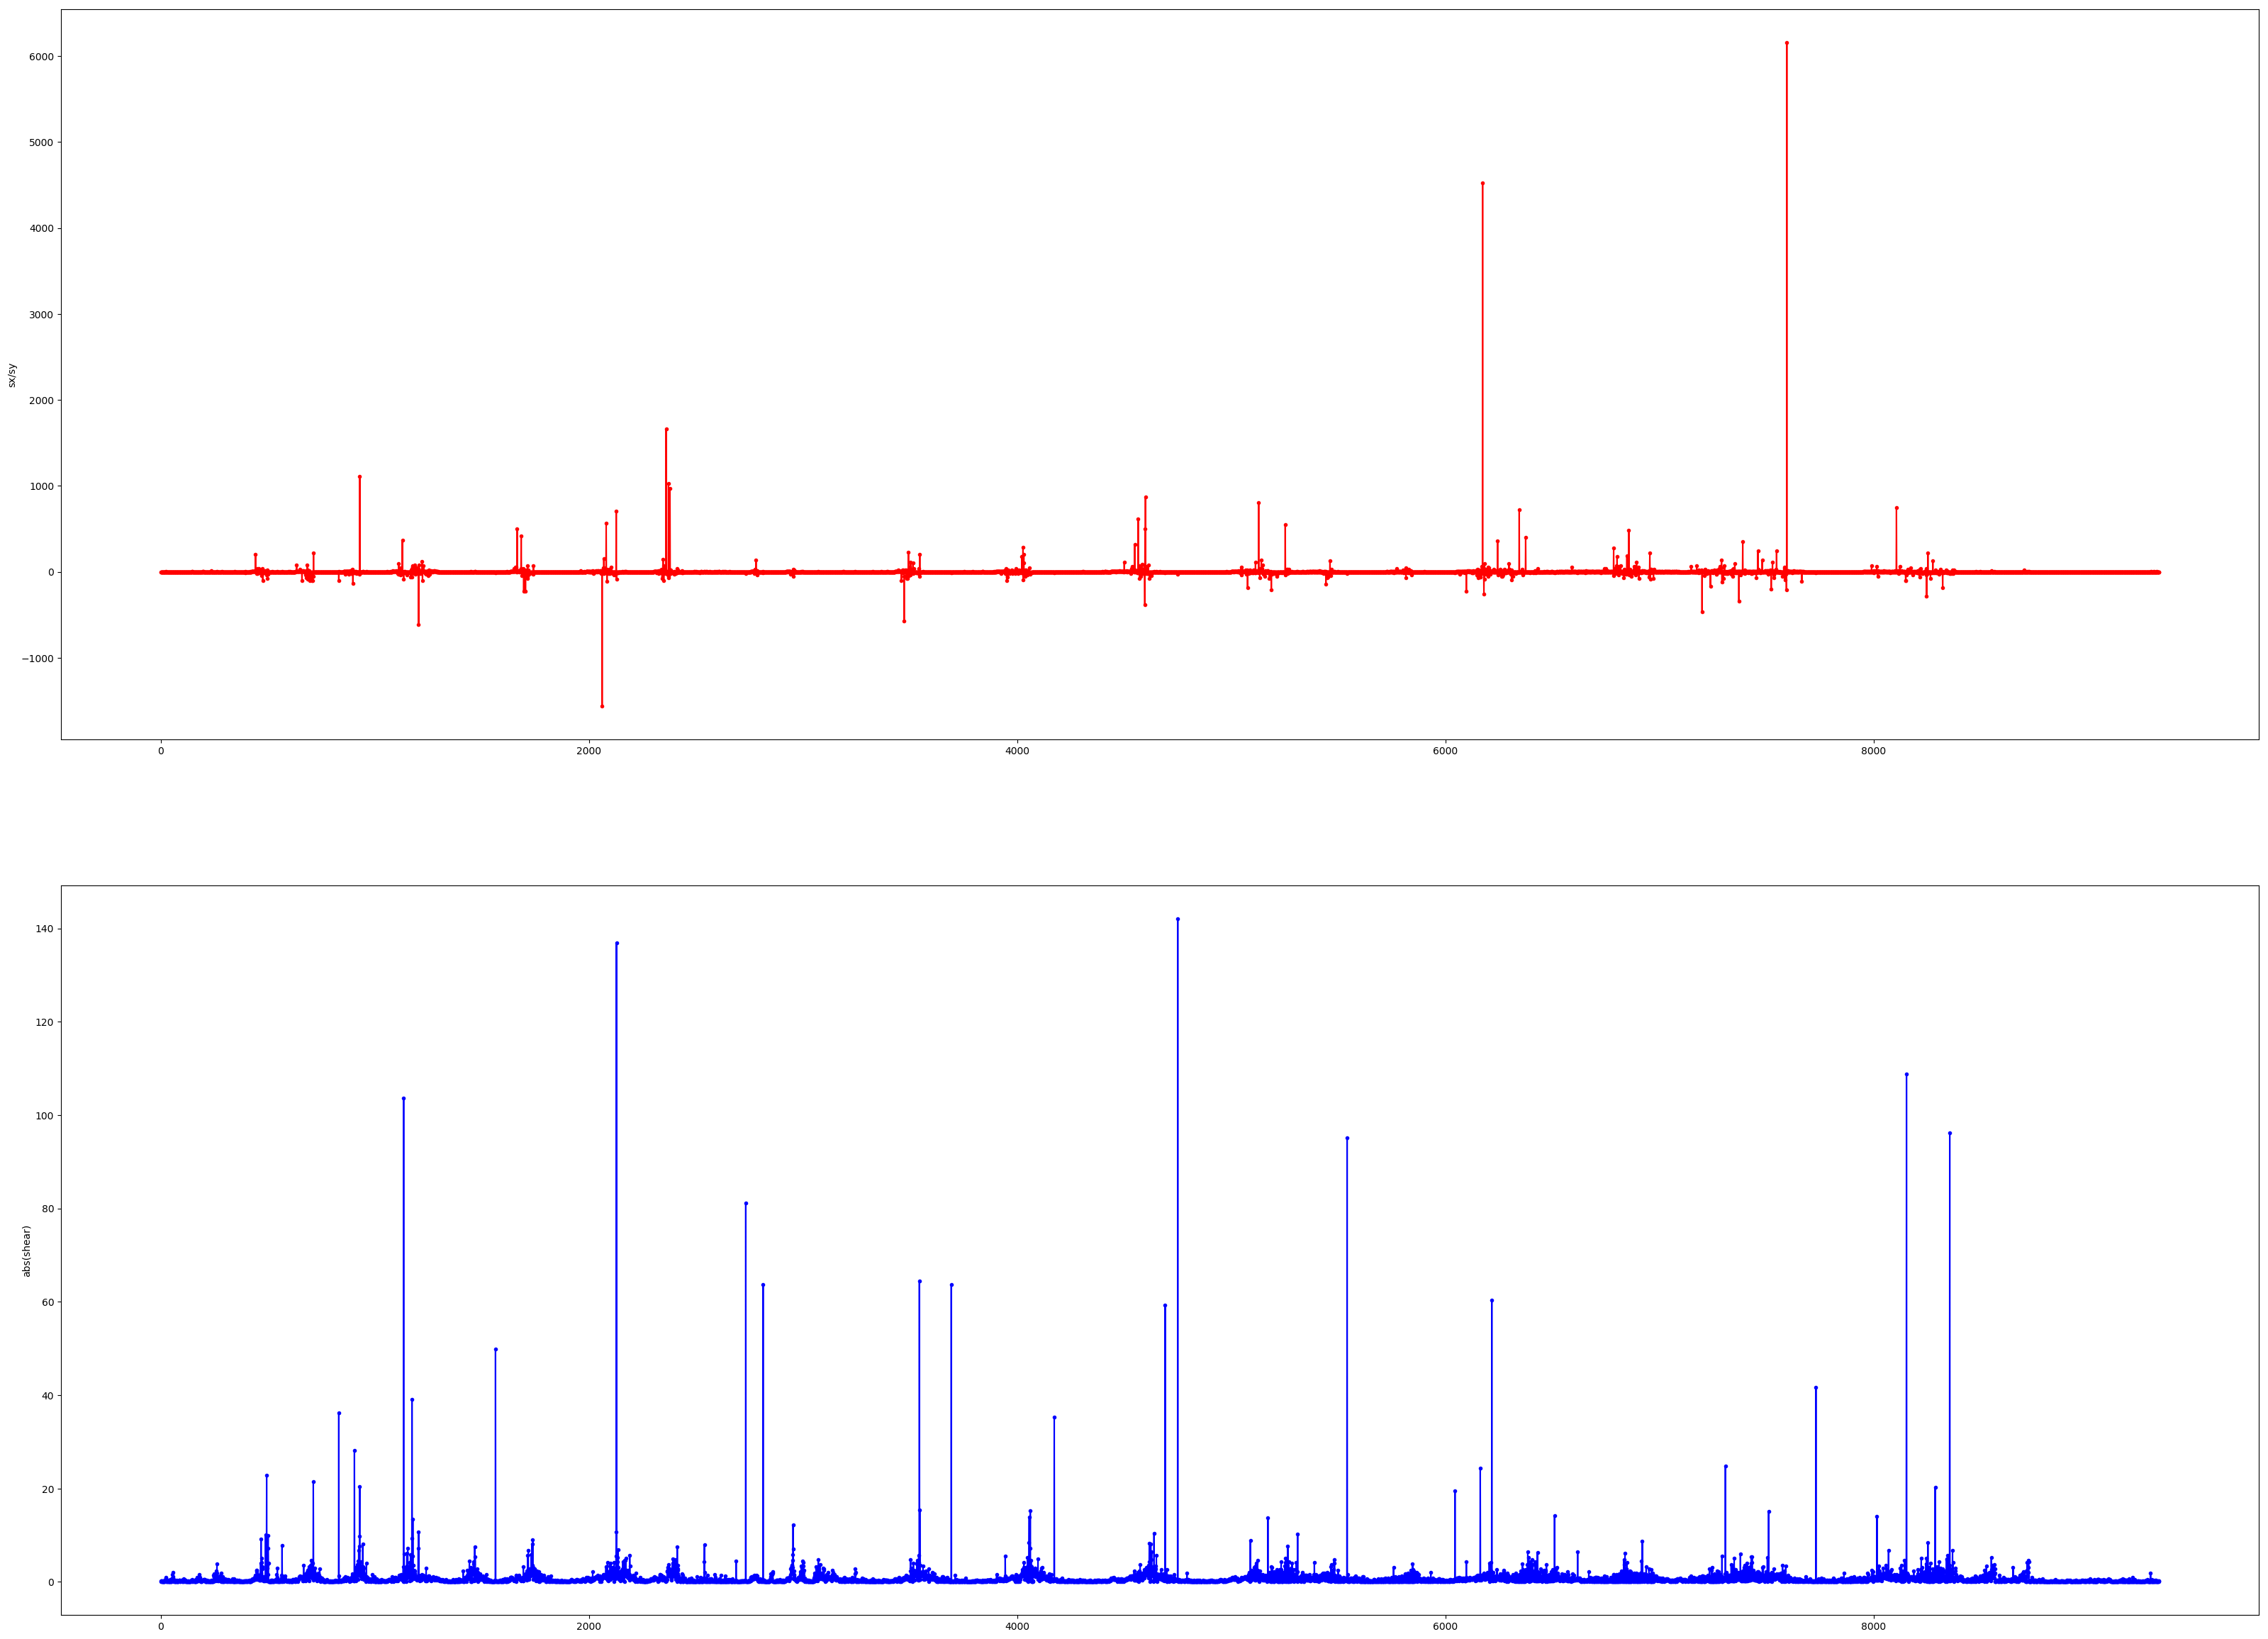

In [195]:
# let explore the camera invariants of images:

def plot_cam_invariants(image_file_names, y_axis1=None, y_axis2=None, use_log1=False, use_log2=False):
    cam_invariants = np.array(
        [image_file_name_to_2d_cam_invariants(image_file_name)
         for image_file_name in image_file_names
        ],
        dtype = "float32")

    fig=plt.figure(figsize=(40, 30), dpi = 100)
    plt.subplot(2, 1, 1)
    if use_log1:
        plt.plot(np.log10(cam_invariants[:,0]), 'r.-')
    else:
        plt.plot(cam_invariants[:,0], 'r.-')
    plt.ylabel('sx/sy')
    if y_axis1:
        plt.axis([0, len(image_file_names), y_axis1[0], y_axis1[1]])
    plt.subplot(2, 1, 2)
    if use_log2:
        plt.plot(np.log10(cam_invariants[:,1]), 'r.-')
    else:
        plt.plot(cam_invariants[:,1], 'b.-')
    plt.ylabel('abs(shear)')
    if y_axis2:
        plt.axis([0, len(work_list_of_images), y_axis2[0], y_axis2[1]])
    plt.show()

plot_cam_invariants(work_list_of_images)

In [196]:
# separate images into good, bad, ugly, invalid categories:

ugly_scale_ratio = 0.1
bad_scale_ratio = 0.45
good_scale_ratio = 0.6

ugly_shear = 1.0
bad_shear = 0.6
good_shear = 0.5

def is_invalid_scale_ratio(scale_ratio):
    return scale_ratio < 0    # case of self-intersecting label

def is_ugly_scale_ratio(scale_ratio):
    return (scale_ratio > 0 and
            scale_ratio < ugly_scale_ratio or
             scale_ratio > 1/ugly_scale_ratio)

def is_bad_scale_ratio(scale_ratio):
    return (not is_ugly_scale_ratio(scale_ratio) and
            (scale_ratio < bad_scale_ratio or
             scale_ratio > 1/bad_scale_ratio))

def is_good_scale_ratio(scale_ratio):
    return (scale_ratio > good_scale_ratio and
             scale_ratio < 1/good_scale_ratio)

def is_border_scale_ratio(scale_ratio):
    return (scale_ratio >= bad_scale_ratio and
            scale_ratio <= good_scale_ratio
            or
            scale_ratio >= 1/good_scale_ratio and
            scale_ratio <= 1/bad_scale_ratio
           )


def is_ugly_shear(shear):
    return shear > ugly_shear

def is_bad_shear(shear):
    return (shear > bad_shear and shear < ugly_shear)

def is_good_shear(shear):
    return shear < good_shear

def is_border_shear(shear):
    return (shear >= good_shear and shear <= bad_shear)


def describe_scale_ratio(scale_ratio):
    if is_invalid_scale_ratio(scale_ratio):
        return 'invalid'
    elif is_ugly_scale_ratio(scale_ratio):
        return 'ugly'
    elif is_bad_scale_ratio(scale_ratio):
        return 'bad'
    elif is_good_scale_ratio(scale_ratio):
        return 'good'
    else:
        return 'bad?'

def describe_shear(shear):
    if is_ugly_shear(shear):
        return 'ugly'
    elif is_bad_shear(shear):
        return 'bad'
    elif is_good_shear(shear):
        return 'good'
    else:
        return 'bad?'

def describe_scale_ratio_and_shear(scale_ratio, shear):
    return 'cam invariants: sx/sy={}({}), shear={}({})'.format(scale_ratio,
                                                               describe_scale_ratio(scale_ratio),
                                                               shear,
                                                               describe_shear(shear))
    

cam_invariants = [image_file_name_to_2d_cam_invariants(image_file_name)
                  for image_file_name in work_list_of_images
                 ]


invalid_images = [image_file_name
                  for i, image_file_name in enumerate(work_list_of_images)
                  if is_invalid_scale_ratio(cam_invariants[i][0])
                 ]
ugly_scale_ratio_images = [image_file_name
                           for i, image_file_name in enumerate(work_list_of_images)
                           if is_ugly_scale_ratio(cam_invariants[i][0])
                          ]
bad_scale_ratio_images = [image_file_name
                          for i, image_file_name in enumerate(work_list_of_images)
                          if is_bad_scale_ratio(cam_invariants[i][0])
                         ]
border_scale_ratio_images = [image_file_name
                             for i, image_file_name in enumerate(work_list_of_images)
                             if is_border_scale_ratio(cam_invariants[i][0])
                            ]
good_scale_ratio_images = [image_file_name
                           for i, image_file_name in enumerate(work_list_of_images)
                           if is_good_scale_ratio(cam_invariants[i][0])
                          ]


ugly_shear_images = [image_file_name
                     for i, image_file_name in enumerate(work_list_of_images)
                     if is_ugly_shear(cam_invariants[i][1])
                    ]
bad_shear_images = [image_file_name
                    for i, image_file_name in enumerate(work_list_of_images)
                    if is_bad_shear(cam_invariants[i][1])
                   ]
border_shear_images = [image_file_name
                       for i, image_file_name in enumerate(work_list_of_images)
                       if is_border_shear(cam_invariants[i][1])
                      ]
good_shear_images = [image_file_name
                     for i, image_file_name in enumerate(work_list_of_images)
                     if is_good_shear(cam_invariants[i][1])
                    ]

good_images = [image_file_name
                     for i, image_file_name in enumerate(work_list_of_images)
                     if is_good_scale_ratio(cam_invariants[i][0]) and is_good_shear(cam_invariants[i][1])
                    ]

print(len(good_images), len(invalid_images))
print(len(ugly_scale_ratio_images), len(bad_scale_ratio_images), len(border_scale_ratio_images), len(good_scale_ratio_images))
print(len(ugly_shear_images), len(bad_shear_images), len(border_shear_images), len(good_shear_images))


4659 1085
443 2324 378 6189
1851 1418 505 5560


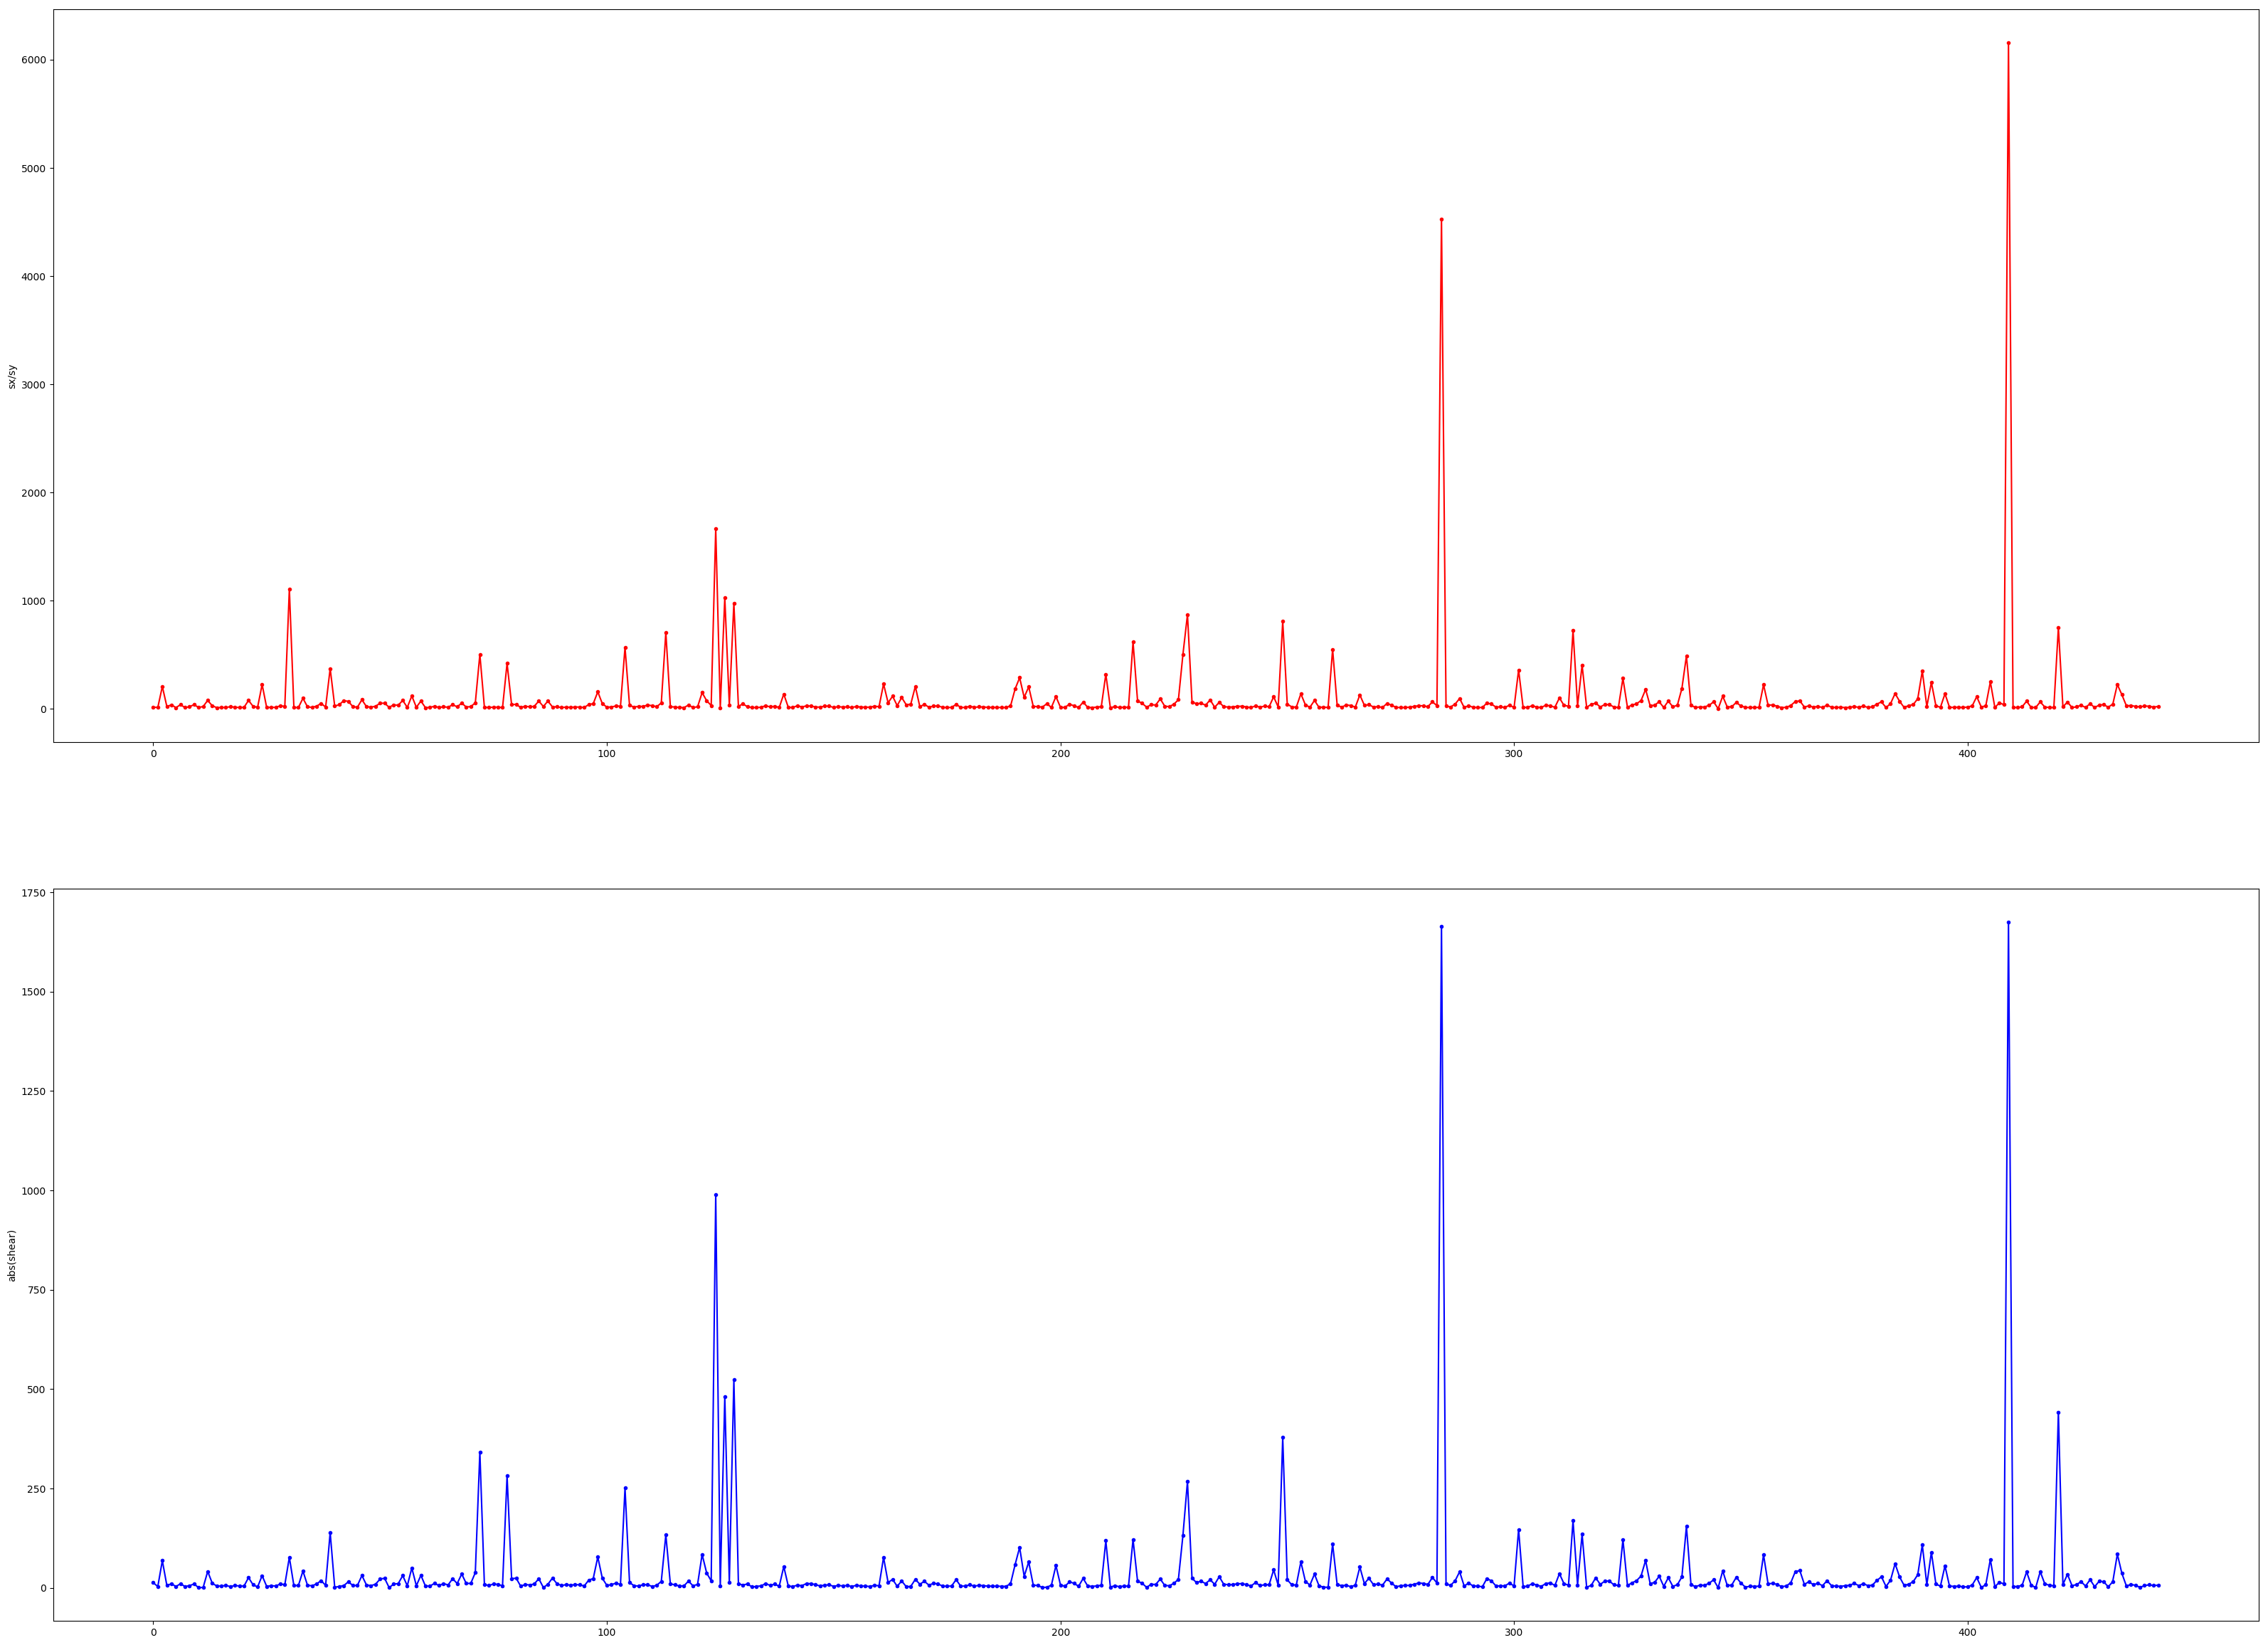

In [165]:
#plot_cam_invariants(good_images, use_log1=True)

plot_cam_invariants(ugly_scale_ratio_images)

In [192]:
def display_explored_image(image_file_name):
    images = labled_image_to_exploration_images(image_file_name)
    display(images['original'].shape)
    cam_invs = image_file_name_to_2d_cam_invariants(image_file_name)
    display(describe_scale_ratio_and_shear(cam_invs[0], cam_invs[1]))
    fig=plt.figure(figsize=(40, 30), dpi = 100)
    #plt.subplot(2, 2, 1)
    #plt.imshow(images['original'])
    #plt.subplot(2, 2, 2)
    #plt.imshow(images['bw'],cmap='gray')
    plt.subplot(1, 2, 1)
    plt.imshow(images['label'])
    plt.subplot(1, 2, 2)
    plt.imshow(images['rectified'])
    plt.show()


In [197]:
interact(display_explored_image, image_file_name=widgets.Dropdown(
    options=ugly_shear_images, #work_list_of_images,
    value=ugly_shear_images[0], #work_list_of_images[0],
    description='Work images:',
    disabled=False,
))


interactive(children=(Dropdown(description='Work images:', options=('IMG_0052.JPG', 'IMG_0118.JPG', 'IMG_0119.…

<function __main__.display_explored_image(image_file_name)>

In [80]:
def write_exploration_images(list_of_image_file_names, path_to_results=path_to_results):
    os.makedirs(path_to_results, exist_ok=True)
    for image_file_name in list_of_image_file_names:
        labled_image_to_exploration_image_file(image_file_name, os.path.join(path_to_results, image_file_name))
